In [113]:
import pandas as pd
import altair as alt

# Need to enable this to allow work with larger datasets (https://altair-viz.github.io/user_guide/faq.html)
#alt.data_transformers.enable('json')
selection = alt.selection_single();

In [114]:
movies_df = pd.read_json('https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json')

# Add a column of the release year
movies_df['Year'] = pd.to_datetime(movies_df['Release_Date']).dt.year
# A list columns that will appear in the final data frame
column_list = ['Title', 'Major_Genre', 'Director', 'Year', 'Worldwide_Gross', 'Production_Budget', 'IMDB_Rating', 'MPAA_Rating']

# Filter out lines with errors or NaNs in 'Director', 'Year', 'Major_Genre' columns
movies_df = (movies_df.query('Year < 2019')
                     .dropna(subset = column_list)
                     .loc[:, column_list]
                     .reset_index()
                     .drop(columns = ['index']))

In [115]:
movies_df.shape

(1414, 8)

In [116]:
movies_df.describe()

,Year,Worldwide_Gross,Production_Budget,IMDB_Rating
count,1414.000000,1.414000e+03,1.414000e+03,1414.000000
mean,2001.524045,1.341416e+08,4.699735e+07,6.443069
std,5.699895,1.901870e+08,4.090067e+07,1.160132
min,1960.000000,0.000000e+00,1.500000e+04,1.700000
25%,1998.000000,2.252175e+07,1.800000e+07,5.700000
50%,2002.000000,6.715760e+07,3.500000e+07,6.500000
75%,2006.000000,1.727553e+08,6.500000e+07,7.300000
max,2010.000000,2.767891e+09,3.000000e+08,9.200000


In [117]:
movies_df.to_csv('../data/clean/movies_clean_df.csv')

In [118]:
def mds_special():
    font = "Arial"
    axisColor = "#000000"
    gridColor = "#DEDDDD"
    return {
        "config": {
            "title": {
                "fontSize": 24,
                "font": font,
                "anchor": "start", # equivalent of left-aligned.
                "fontColor": "#000000"
            },
            'view': {
                "height": 300, 
                "width": 400
            },
            "axisX": {
                "domain": True,
                #"domainColor": axisColor,
                "gridColor": gridColor,
                "domainWidth": 1,
                "grid": False,
                "labelFont": font,
                "labelFontSize": 12,
                "labelAngle": 0, 
                "tickColor": axisColor,
                "tickSize": 5, # default, including it just to show you can change it
                "titleFont": font,
                "titleFontSize": 16,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "X Axis Title (units)", 
            },
            "axisY": {
                "domain": False,
                "grid": True,
                "gridColor": gridColor,
                "gridWidth": 1,
                "labelFont": font,
                "labelFontSize": 14,
                "labelAngle": 0, 
                #"ticks": False, # even if you don't have a "domain" you need to turn these off.
                "titleFont": font,
                "titleFontSize": 16,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "Y Axis Title (units)", 
                # titles are by default vertical left of axis so we need to hack this 
                #"titleAngle": 0, # horizontal
                #"titleY": -10, # move it up
                #"titleX": 18, # move it to the right so it aligns with the labels 
            },
        }
    }

In [119]:
def get_top_director(selected_df, num, genre):
    """
    Finds the number of movies of the most productive directors in the selected genre

    Parameters
    ----------
    movies_df: pandas.DataFrame
        The data frame to work on
    num: int
        The number of directors to keep in each genre
    genre: string
        The selected genre

    Returns
    -------
    pandas.DataFrame
        The data frame contains the number of movies of the most productive directors in the selected genre
    """

    mdfg = selected_df.groupby('Major_Genre')
    return (mdfg.get_group(genre)
                .groupby('Director')
                .count()
                .sort_values(by = 'Title', ascending = False)
                .head(num)
                .reset_index()
                .iloc[:, :2]
                .rename(columns = {'Title': 'Count'}))

In [120]:
def get_top_df(selected_df, num, genre):
    """
    Finds movie information from the most productive directors in the selected genre

    Parameters
    ----------
    movies_df: pandas.DataFrame
        The data frame to work on
    num: int
        The number of directors to keep in each genre
    genre: string
        The selected genre

    Returns
    -------
    pandas.DataFrame
        The data frame only contains movie information from the most productive directors in the selected genre
    """

    
    top_director = get_top_director(selected_df, num, genre)
    top_director['Major_Genre'] = genre
    return pd.merge(selected_df, 
                    top_director, 
                    how = "inner", 
                    on = ['Major_Genre', 'Director'])

In [121]:
get_top_df(movies_df, 1, 'Action')

,Title,Major_Genre,Director,Year,Worldwide_Gross,Production_Budget,IMDB_Rating,MPAA_Rating,Count
0,Bad Boys,Action,Michael Bay,1995,141247413.0,23000000.0,6.6,R,7
1,The Rock,Action,Michael Bay,1996,336069511.0,75000000.0,7.2,R,7
2,Bad Boys II,Action,Michael Bay,2003,272940870.0,130000000.0,6.2,R,7
3,The Island,Action,Michael Bay,2005,163018913.0,120000000.0,6.9,PG-13,7
4,Pearl Harbor,Action,Michael Bay,2001,449239855.0,151500000.0,5.4,PG-13,7
5,Transformers,Action,Michael Bay,2007,708272592.0,151000000.0,7.3,PG-13,7
6,Transformers: Revenge of the Fallen,Action,Michael Bay,2009,836303693.0,210000000.0,6.0,PG-13,7


In [170]:
def make_bar_plot(genre = 'Action', year = (1933, 2010)):
    # Don't forget to include imports
    # register the custom theme under a chosen name
    alt.themes.register('mds_special', mds_special)

    # enable the newly registered theme
    alt.themes.enable('mds_special')
    #alt.themes.enable('none') # to return to default
    
    # get the clean movies data
    movies_df = pd.read_csv('../data/clean/movies_clean_df.csv', index_col = 0)
    # get information from the 30 most productive directors in the selected genre
    selected_df = movies_df[(movies_df['Year'] > year[0]) & (movies_df['Year'] < year[1])]
    top_director = get_top_director(selected_df, 30, genre)
    
    # Create a bar graph of the 30 most productive directors in the selected genre
    return alt.Chart(top_director).mark_bar().encode(
                alt.Y('Director:N', title = 'Director'),
                alt.X('Count:Q', title = 'Number of movies')
            ).properties(
                title = 'Top 30 productive directors in ' + genre,
                width = 300, 
                height = 350).add_selection(brush)

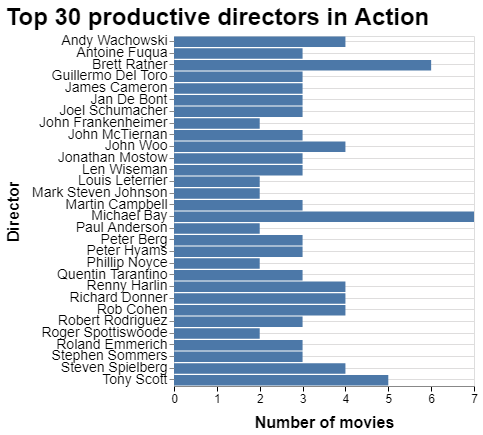

In [171]:
make_bar_plot(genre = 'Action', year = (1990, 2010))

In [109]:
def make_scatter_plot(genre = 'Action', year = (1933, 2010)):
    # Don't forget to include imports
    
    # register the custom theme under a chosen name
    alt.themes.register('mds_special', mds_special)

    # enable the newly registered theme
    alt.themes.enable('mds_special')
    #alt.themes.enable('none') # to return to default
    
    # get the clean movies data
    movies_df = pd.read_csv('../data/clean/movies_clean_df.csv', index_col = 0)
    # get information from the 30 most productive directors in the selected genre
    selected_df = movies_df[(movies_df['Year'] > year[0]) & (movies_df['Year'] < year[1])]
    top_df = get_top_df(selected_df, 30, genre)
    
    # Create scatter plots of rating and profits


    return chart

In [110]:
make_bar_plot()

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [84]:
def make_text_plot(genre = 'Action', year = (1933, 2010), number_of_directors=30):
    # Don't forget to include imports
    
    # register the custom theme under a chosen name
    alt.themes.register('mds_special', mds_special)

    # enable the newly registered theme
    alt.themes.enable('mds_special')
    #alt.themes.enable('none') # to return to default
    
    # get the clean movies data
    movies_df = pd.read_csv('../data/clean/movies_clean_df.csv', index_col = 0)
    # get information from the 30 most productive directors in the selected genre
    selected_df = movies_df[(movies_df['Year'] > year[0]) & (movies_df['Year'] < year[1])]
    top_df = get_top_df(selected_df, number_of_directors, genre)

    return alt.Chart(top_df).encode(
                alt.X('Director:N', title = 'Director'),
                alt.Y('Year:O', title = 'Year')
            ).mark_text(
            align='left',
            baseline='middle',  # Nudges text to right so it doesn't appear on top of the bar
            ).encode(
            text='Title:N'
            ).properties(
                title = 'Movie titles for director',
                width = 600, 
                height = 650).interactive()

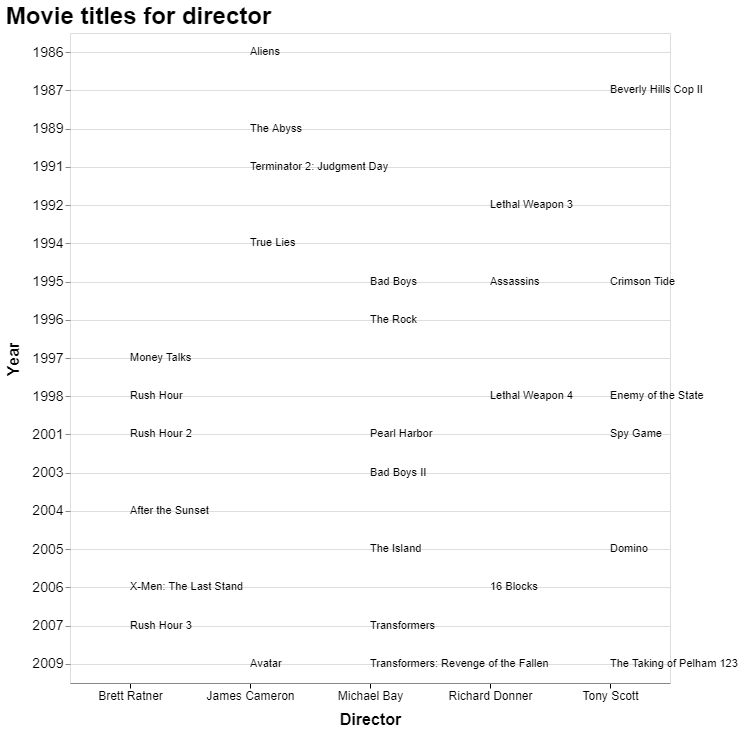

In [85]:
make_text_plot(genre = 'Action', year = (1933, 2010), number_of_directors = 5)

In [239]:
def make_text_plot2(genre = 'Action', year = (1933, 2010), number_of_directors = 30):
    # Don't forget to include imports
    
    # register the custom theme under a chosen name
    alt.themes.register('mds_special', mds_special)
    brush = alt.selection(type='interval', encodings=['y'])

    # enable the newly registered theme
    alt.themes.enable('mds_special')
    #alt.themes.enable('none') # to return to default
    
    # get the clean movies data
    movies_df = pd.read_csv('../data/clean/movies_clean_df.csv', index_col = 0)
    # get information from the 30 most productive directors in the selected genre
    selected_df = movies_df[(movies_df['Year'] > year[0]) & (movies_df['Year'] < year[1])]
    top_df = get_top_df(selected_df, number_of_directors, genre)
    top_director = get_top_director(selected_df, 30, genre)
    
    chart1= alt.Chart(top_df).mark_bar().encode(
                alt.Y('Director:N', title = 'Director'),
                alt.X('Count:Q', title = 'Proportion of MPAA Rating', stack="normalize"),
                alt.Color('MPAA_Rating:N'),
                opacity=alt.condition(brush, alt.value(0.75), alt.value(0.05))
            ).properties(
                title = 'Proportions of MPAA Ratings by director',
                width = 300, 
                height = 350).interactive()
    chart2 = alt.Chart(top_director).mark_bar().encode(
                alt.Y('Director:N', title = 'Director', sort=alt.EncodingSortField(
            field="Worldwide_Gross",  
            order="ascending")),
                alt.X('Count:Q', title = 'Number of movies')
            ).properties(
                title = 'Top 30 productive directors in ' + genre,
                width = 300, 
                height = 750).add_selection(brush)
    chart3 = alt.Chart(top_df).mark_line().encode(
                alt.X("Year:O"),
                alt.Y("IMDB_Rating:Q", axis=alt.Axis(title="Mark"), scale=alt.Scale(zero=False)),
                alt.Color('Director:N'),
                opacity=alt.condition(brush, alt.value(0.75), alt.value(0.05)),
                tooltip = ['Title', 'Major_Genre', 'Director', 'IMDB_Rating']
            ).properties(title='Rating',
                        width=500, height=250).interactive()
    chart4 = alt.Chart(top_df).mark_line().encode(
            alt.X("Year:O"),
            alt.Y("Worldwide_Gross:Q", axis=alt.Axis(title="Mark"), scale=alt.Scale(zero=False)),
            alt.Color('Director:N'),
            opacity=alt.condition(brush, alt.value(0.75), alt.value(0.05)),
            tooltip = ['Title', 'Major_Genre', 'Director', 'IMDB_Rating']
            ).properties(title='Worldwide Gross',
                        width=500, height=250).interactive()
    return chart2 | alt.vconcat(chart4 & chart3)

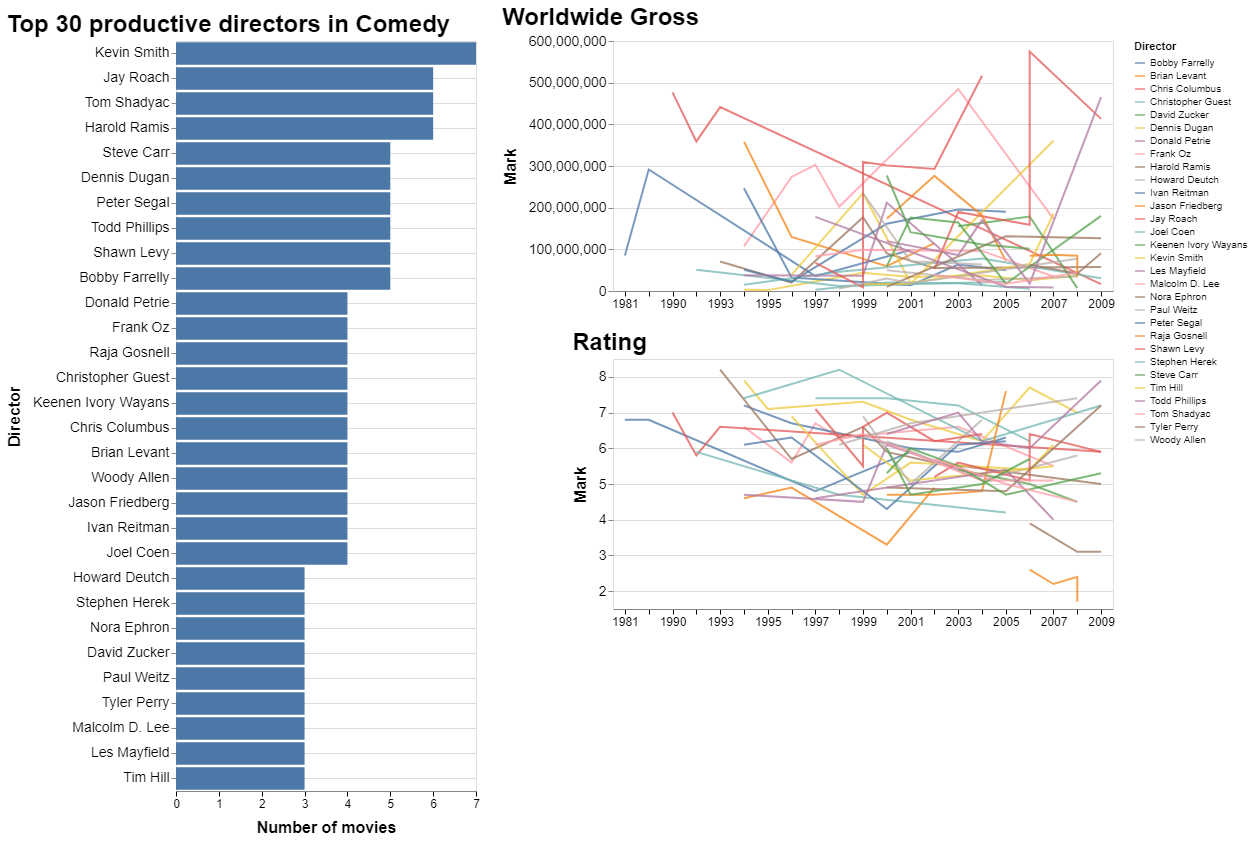

In [240]:
make_text_plot2(genre = 'Comedy', year = (1933, 2010)) 

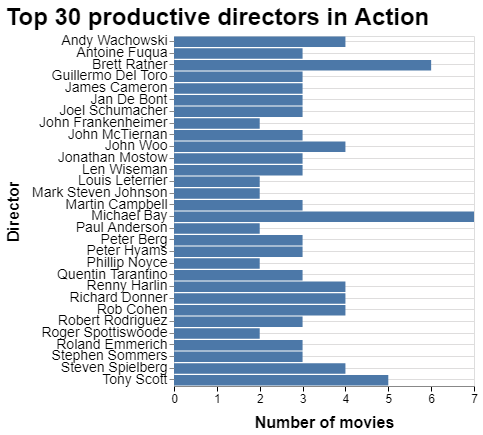

In [191]:
make_bar_plot(genre = 'Action', year = (1990, 2010))

In [ ]:
def make_plot_1(genre="Action", director="James Cameron"):